<h1 align=center><font size = 6>Classify Trees in Satellite Imagery</font></h1>
<img src="https://eoimages.gsfc.nasa.gov/images/imagerecords/40000/40228/moorhead_tm5_2009253.jpg" width=1000 height=400 alt="esto.nasa.gov"/>

<small>Picture Source:<a href="https://eoimages.gsfc.nasa.gov/">NASA</a>

<br>

<p>Tree detection can be used for applications such as vegetation management, forestry, urban planning, etc. Tree identifications are very important in terms of impending famine and forest fires.</p>

<br>

<h2>Objective</h2>

<ul>
  <li>Create a dataset object with <b>Trees in Satellite Imagery</b> dataset.</li>
  <li>Understand the dataset & cleanup (if required).</li>
  <li>Build classification models to predict the tree class.</li>
  <li>Build class activation maps (CAM).</li>
</ul> 

<br>

<h2>About Dataset</h2>

<p>This dataset is being used for classifying the land with class of trees or not in geospatial images.</p>

Satellite: [Sentinel - 2](https://sentinel.esa.int/web/sentinel/missions/sentinel-2)

<h3>Context</h3>

<p>The content architecture is simple. Each datum has 64x64 resolution and located under <i>tree</i> and <i>notree</i> folders.
Each folder (class) has 5200 images. So the total dataset has 10.4K images.</p>

To download the dataset, you need to have a kaggle account.

 - Dataset download link: [Kaggle](https://www.kaggle.com/datasets/mcagriaksoy/trees-in-satellite-imagery/download?datasetVersionNumber=1)
 - Dataset website: [Kaggle Trees in Satellite Imagery](https://www.kaggle.com/datasets/mcagriaksoy/trees-in-satellite-imagery)

<br>

<h2>Table of Contents</h2>

<div class="alert alert-block alert-info" style="margin-top: 20px">

<li><a href="https://#import">Import Libraries and Packages</a></li>
<li><a href="https://#data_preparation">Dataset Preparation</a></li>
<li><a href="https://#compile_fit">Compile and Fit the Model</a></li>
<li><a href="https://#build_cam">Building Class Activation Maps</a></li>
<li><a href="https://#make_dataframe">Make Dataframe for the Predictions</a></li>
<li><a href="https://#upload_predict">Upload and Predict Your Picture!</a></li>
<br>

<p></p>
Estimated Time Needed: <strong>45 min</strong>
</div>

<br>
<h2 align=center id="import">Import Libraries and Packages</h2>
<p>The following are the libraries we are going to use for this lab:</p>

In [ ]:
#from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D
from keras.applications.vgg16 import preprocess_input

In [ ]:
from sklearn.utils import shuffle

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2
import seaborn as sns

In [ ]:
import os
import shutil

In [ ]:
import datetime

In [ ]:
# Print Tensorflow version
print(tf.__version__)

2.9.2


<br>
<h2 align=center id="data_preparation">Dataset Preparation</h2>

<p>We are going to separate our dataset.</p>

In [ ]:
!unzip -q archive.zip

In [ ]:
num_classes = 2 #@param {type:"number"}
image_resize = 224 #@param {type:"number"}
batch_size_training = 10 #@param {type:"number"}
batch_size_validation = 10 #@param {type:"number"}

In [ ]:
def train_test_split():
    print("Splitting Started!\n\n")

    root_dir = '/content/'
    classes_dir = ['Trees', 'NoTrees']

    processed_dir = '/content/Trees in Satellite Imagery'

    val_ratio = 0.10
    test_ratio = 0.20

    for cls in classes_dir:
        # Creating partitions of the data after shuffeling
        print("\n Class Name " + cls)
        src = processed_dir +"//" + cls  # Folder to copy images from

        allFileNames = os.listdir(src)
        np.random.shuffle(allFileNames)
        train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                                  [int(len(allFileNames) * (1 - (val_ratio + test_ratio))),
                                                                   int(len(allFileNames) * (1 - val_ratio)),
                                                                   ])

        train_FileNames = [src + '//' + name for name in train_FileNames.tolist()]
        val_FileNames = [src + '//' + name for name in val_FileNames.tolist()]
        test_FileNames = [src + '//' + name for name in test_FileNames.tolist()]

        print('Total images: '+ str(len(allFileNames)))
        print('Training: '+ str(len(train_FileNames)))
        print('Validation: '+  str(len(val_FileNames)))
        print('Testing: '+ str(len(test_FileNames)))

        # # Creating Train / Val / Test folders (One time use)
        os.makedirs(root_dir + '/train//' + cls)
        os.makedirs(root_dir + '/val//' + cls)
        os.makedirs(root_dir + '/test//' + cls)

        # Copy-pasting images
        for name in train_FileNames:
            shutil.copy(name, root_dir + '/train//' + cls)

        for name in val_FileNames:
            shutil.copy(name, root_dir + '/val//' + cls)

        for name in test_FileNames:
            shutil.copy(name, root_dir + '/test//' + cls)

    print("\n\nSplitting Ended!")

In [ ]:
train_test_split()

Splitting Started!



 Class Name Trees
Total images: 5200
Training: 3639
Validation: 1041
Testing: 520

 Class Name NoTrees
Total images: 5200
Training: 3639
Validation: 1041
Testing: 520


Splitting Ended!


In [ ]:
train_dir = '/content/train/'
test_dir = '/content/test/'
validation_dir = '/content/val/'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

In [ ]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

In [ ]:
val_paths = []
val_labels = []

for label in os.listdir(validation_dir):
    for image in os.listdir(validation_dir+label):
        val_paths.append(validation_dir+label+'/'+image)
        val_labels.append(label)

val_paths, val_labels = shuffle(val_paths, val_labels)

In [ ]:
test_paths = np.array(test_paths)
train_paths = np.array(train_paths)
val_paths = np.array(val_paths)

In [ ]:
def one_hot(array):
    unique, inverse = np.unique(array, return_inverse=True)
    onehot = np.eye(unique.shape[0])[inverse]
    return onehot

In [ ]:
test_label_ohe = one_hot(test_labels)
train_label_ohe = one_hot(train_labels)
val_label_ohe = one_hot(val_labels)

In [ ]:
train_df = pd.DataFrame(train_labels, columns = ['Label'])
train_df['img_path'] = train_paths.tolist()
print(train_df.shape)
train_df.head()

(7278, 2)


,Label,img_path
0,Trees,/content/train/Trees/Forest_1742.jpg
1,NoTrees,/content/train/NoTrees/Industrial_2121.jpg
2,NoTrees,/content/train/NoTrees/SeaLake_1468.jpg
3,NoTrees,/content/train/NoTrees/Industrial_1256.jpg
4,Trees,/content/train/Trees/Forest_1134.jpg


In [ ]:
test_df = pd.DataFrame(test_labels, columns = ['Label'])
test_df['img_path'] = test_paths.tolist()
print(test_df.shape)
test_df.head()

(1040, 2)


,Label,img_path
0,NoTrees,/content/test/NoTrees/AnnualCrop_552.jpg
1,NoTrees,/content/test/NoTrees/Industrial_1972.jpg
2,NoTrees,/content/test/NoTrees/Industrial_2173.jpg
3,Trees,/content/test/Trees/Forest_320.jpg
4,NoTrees,/content/test/NoTrees/Industrial_91.jpg


In [ ]:
val_df = pd.DataFrame(val_labels, columns = ['Label'])
val_df['img_path'] = val_paths.tolist()
print(val_df.shape)
val_df.head()

(2082, 2)


,Label,img_path
0,Trees,/content/val/Trees/River_349.jpg
1,NoTrees,/content/val/NoTrees/SeaLake_454.jpg
2,NoTrees,/content/val/NoTrees/SeaLake_755.jpg
3,Trees,/content/val/Trees/River_1593.jpg
4,Trees,/content/val/Trees/Forest_604.jpg


In [ ]:
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1./255, validation_split=0.25)

In [ ]:
train_generator=data_generator.flow_from_dataframe(
  dataframe=train_df,
  directory=train_dir,
  x_col="img_path",
  y_col="Label",
  subset="training",
  batch_size=batch_size_training,
  seed=42,
  shuffle=True,
  class_mode="categorical",
  target_size=(image_resize, image_resize))

validation_generator=data_generator.flow_from_dataframe(
  dataframe=val_df,
  directory=validation_dir,
  x_col="img_path",
  y_col="Label",
  subset="validation",
  batch_size=batch_size_validation,
  seed=42,
  shuffle=True,
  class_mode="categorical",
  target_size=(image_resize, image_resize))

Found 5459 validated image filenames belonging to 2 classes.
Found 520 validated image filenames belonging to 2 classes.


In [ ]:
test_df.to_csv('test_df.csv')
train_df.to_csv('train_df.csv')
val_df.to_csv('val_df.csv')

In [ ]:
class_mapping = train_generator.class_indices
class_mapping

{'NoTrees': 0, 'Trees': 1}

<p>Let's plot our first 4 images in the batch and print batches.</p>

In [ ]:
first_batch = train_generator.next()
first_batch

(array([[[[ 0.59239614,  0.53812164,  0.51498044],
          [ 0.59239614,  0.53812164,  0.51498044],
          [ 0.59239614,  0.53812164,  0.51498044],
          ...,
          [ 0.35710198,  0.24400394,  0.28360787],
          [ 0.35710198,  0.24400394,  0.28360787],
          [ 0.35710198,  0.24400394,  0.28360787]],
 
         [[ 0.59239614,  0.53812164,  0.51498044],
          [ 0.59239614,  0.53812164,  0.51498044],
          [ 0.59239614,  0.53812164,  0.51498044],
          ...,
          [ 0.35710198,  0.24400394,  0.28360787],
          [ 0.35710198,  0.24400394,  0.28360787],
          [ 0.35710198,  0.24400394,  0.28360787]],
 
         [[ 0.59239614,  0.53812164,  0.51498044],
          [ 0.59239614,  0.53812164,  0.51498044],
          [ 0.59239614,  0.53812164,  0.51498044],
          ...,
          [ 0.35710198,  0.24400394,  0.28360787],
          [ 0.35710198,  0.24400394,  0.28360787],
          [ 0.35710198,  0.24400394,  0.28360787]],
 
         ...,
 
         [[ 

In [ ]:
first_batch_images = train_generator.next()[0]
first_batch_images

array([[[[-0.125251  , -0.19521177, -0.34384316],
         [-0.125251  , -0.19521177, -0.34384316],
         [-0.125251  , -0.19521177, -0.34384316],
         ...,
         [-0.12917256, -0.23442747, -0.33600003],
         [-0.12917256, -0.23442747, -0.33600003],
         [-0.12917256, -0.23442747, -0.33600003]],

        [[-0.125251  , -0.19521177, -0.34384316],
         [-0.125251  , -0.19521177, -0.34384316],
         [-0.125251  , -0.19521177, -0.34384316],
         ...,
         [-0.12917256, -0.23442747, -0.33600003],
         [-0.12917256, -0.23442747, -0.33600003],
         [-0.12917256, -0.23442747, -0.33600003]],

        [[-0.125251  , -0.19521177, -0.34384316],
         [-0.125251  , -0.19521177, -0.34384316],
         [-0.125251  , -0.19521177, -0.34384316],
         ...,
         [-0.12917256, -0.23442747, -0.33600003],
         [-0.12917256, -0.23442747, -0.33600003],
         [-0.12917256, -0.23442747, -0.33600003]],

        ...,

        [[-0.09387845, -0.2030549 , -0

In [ ]:
first_batch[1]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

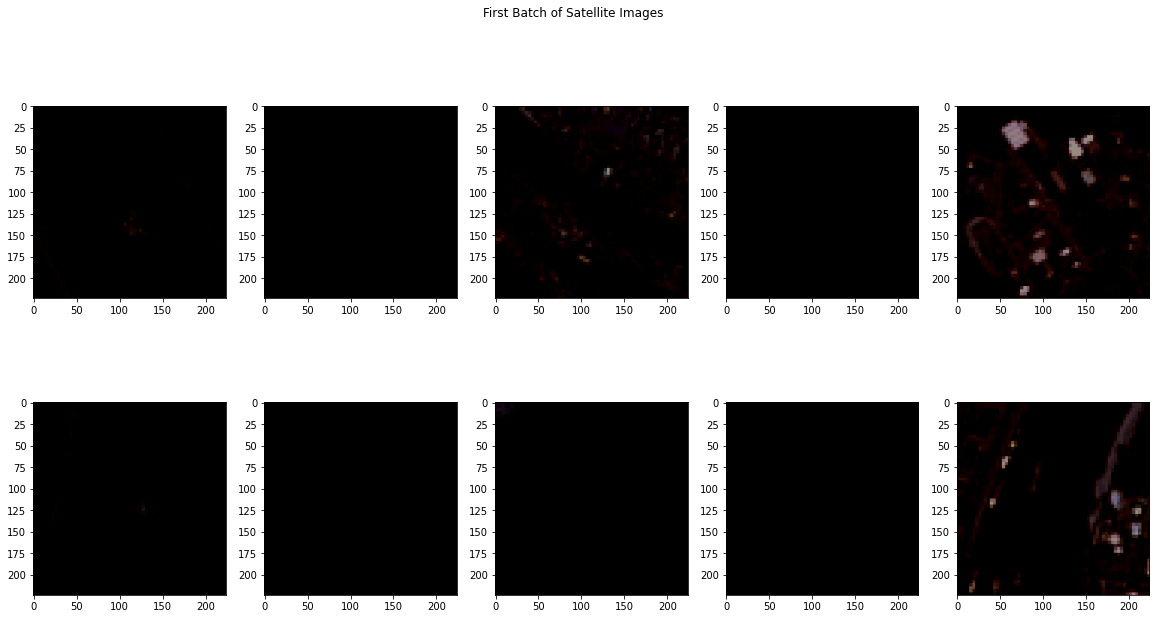

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))

ind = 0
for ax1 in axs:
  for ax2 in ax1: 
    image_data = first_batch_images[ind]
    #image_data = first_batch_images[ind].astype(np.uint8)
    ax2.imshow(image_data)
    ind += 1

fig.suptitle('First Batch of Satellite Images') 
plt.show()

In [ ]:
second_batch_images=train_generator.next()[0]
print(second_batch_images)

[[[[-0.11740786 -0.26187843 -0.39874512]
   [-0.11740786 -0.26187843 -0.39874512]
   [-0.11740786 -0.26187843 -0.39874512]
   ...
   [-0.11740786 -0.27364314 -0.38305885]
   [-0.11740786 -0.27364314 -0.38305885]
   [-0.11740786 -0.27364314 -0.38305885]]

  [[-0.11740786 -0.26187843 -0.39874512]
   [-0.11740786 -0.26187843 -0.39874512]
   [-0.11740786 -0.26187843 -0.39874512]
   ...
   [-0.11740786 -0.27364314 -0.38305885]
   [-0.11740786 -0.27364314 -0.38305885]
   [-0.11740786 -0.27364314 -0.38305885]]

  [[-0.11740786 -0.26187843 -0.39874512]
   [-0.11740786 -0.26187843 -0.39874512]
   [-0.11740786 -0.26187843 -0.39874512]
   ...
   [-0.11740786 -0.27364314 -0.38305885]
   [-0.11740786 -0.27364314 -0.38305885]
   [-0.11740786 -0.27364314 -0.38305885]]

  ...

  [[-0.125251   -0.2658     -0.39482355]
   [-0.125251   -0.2658     -0.39482355]
   [-0.125251   -0.2658     -0.39482355]
   ...
   [-0.10956472 -0.2658     -0.39482355]
   [-0.10956472 -0.2658     -0.39482355]
   [-0.10956472 

In [ ]:
third_batch_images=train_generator.next()[0]
print(third_batch_images)

[[[[-9.78000164e-02 -1.71682358e-01 -3.12470615e-01]
   [-9.78000164e-02 -1.71682358e-01 -3.12470615e-01]
   [-9.78000164e-02 -1.71682358e-01 -3.12470615e-01]
   ...
   [-8.60353112e-02 -1.67760789e-01 -3.12470615e-01]
   [-8.60353112e-02 -1.67760789e-01 -3.12470615e-01]
   [-8.60353112e-02 -1.67760789e-01 -3.12470615e-01]]

  [[-9.78000164e-02 -1.71682358e-01 -3.12470615e-01]
   [-9.78000164e-02 -1.71682358e-01 -3.12470615e-01]
   [-9.78000164e-02 -1.71682358e-01 -3.12470615e-01]
   ...
   [-8.60353112e-02 -1.67760789e-01 -3.12470615e-01]
   [-8.60353112e-02 -1.67760789e-01 -3.12470615e-01]
   [-8.60353112e-02 -1.67760789e-01 -3.12470615e-01]]

  [[-9.78000164e-02 -1.71682358e-01 -3.12470615e-01]
   [-9.78000164e-02 -1.71682358e-01 -3.12470615e-01]
   [-9.78000164e-02 -1.71682358e-01 -3.12470615e-01]
   ...
   [-8.60353112e-02 -1.67760789e-01 -3.12470615e-01]
   [-8.60353112e-02 -1.67760789e-01 -3.12470615e-01]
   [-8.60353112e-02 -1.67760789e-01 -3.12470615e-01]]

  ...

  [[-9.38784

In [ ]:
labels = np.array(['NoTrees', 'Trees'])

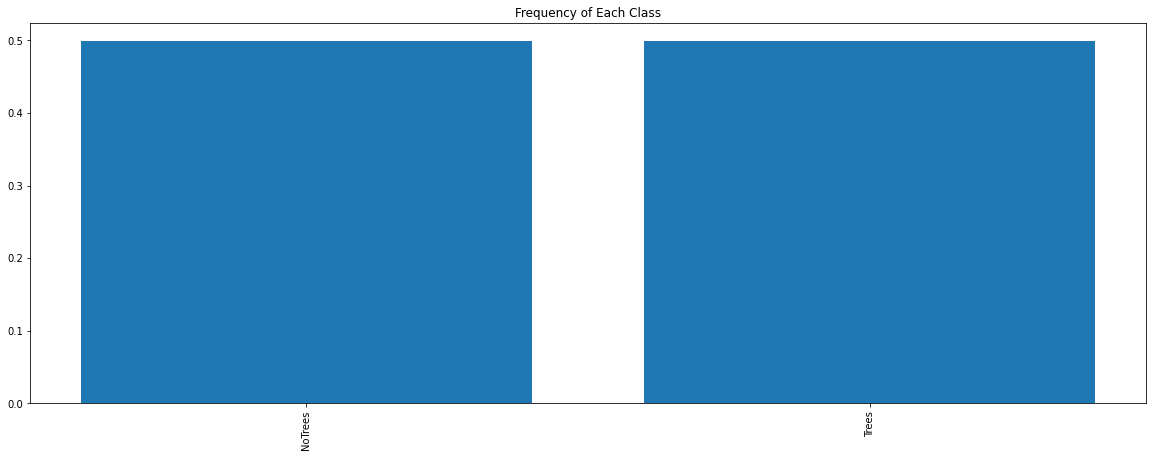

In [ ]:
plt.figure(figsize=(20, 7))
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

<p>Using this formulation, we can see that if there is a large imbalance with very few positive training cases, for example, then the loss will be dominated by the negative class. Summing the contribution over all the training cases for each class (i.e. pathological condition), we see that the contribution of each class (i.e. positive or negative) is: </p>

$$freq_{p} = \frac{\text{number of positive examples}}{N} $$

$$\text{and}$$

$$freq_{n} = \frac{\text{number of negative examples}}{N}.$$

In [ ]:
def compute_class_freqs(labels):
    
  # total number of patients (rows)
  N = np.shape(labels)[0]
  
  positive_frequencies = np.sum(labels, axis = 0) / N
  negative_frequencies = 1 - positive_frequencies

  return positive_frequencies, negative_frequencies

In [ ]:
np.shape(labels)[0]

2

In [ ]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)

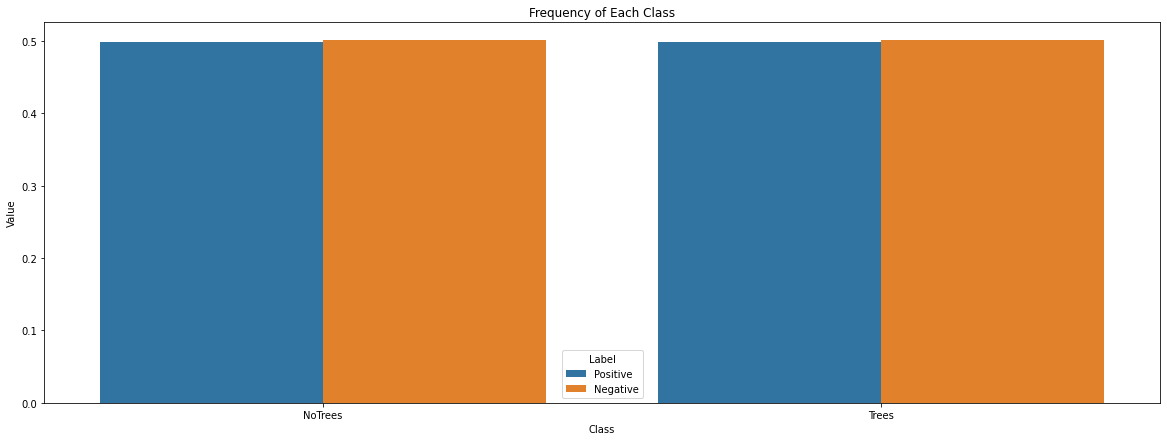

In [ ]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
for i in range(2):
  data = data.append([{"Class": labels[i], "Label": "Negative", "Value": freq_neg}])
plt.figure(figsize=(20, 7))
plt.title("Frequency of Each Class")
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

<br>
<h2 align=center id="compile_fit">Compile and Fit the Model</h2>

In [ ]:
#load_model('/content/model.h5')

In [ ]:
def model_block(inputs, num_classes):
 
  model = Sequential([
    
    layers.Conv2D(16, input_shape=(image_resize, image_resize, 3), kernel_size=(3,3),activation='relu',padding='same'),        
    layers.MaxPooling2D(pool_size=(2,2)),

    layers.Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2,2)),

    layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2,2)),

    layers.Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(num_classes, activation='softmax')
  
  ])
  model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=tf.keras.optimizers.RMSprop(lr=0.001))
  model.summary()
  
  return model

In [ ]:
model = model_block(224, 2) # 224x224 as pixels and 2 as tree classes

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 28, 28, 64)      

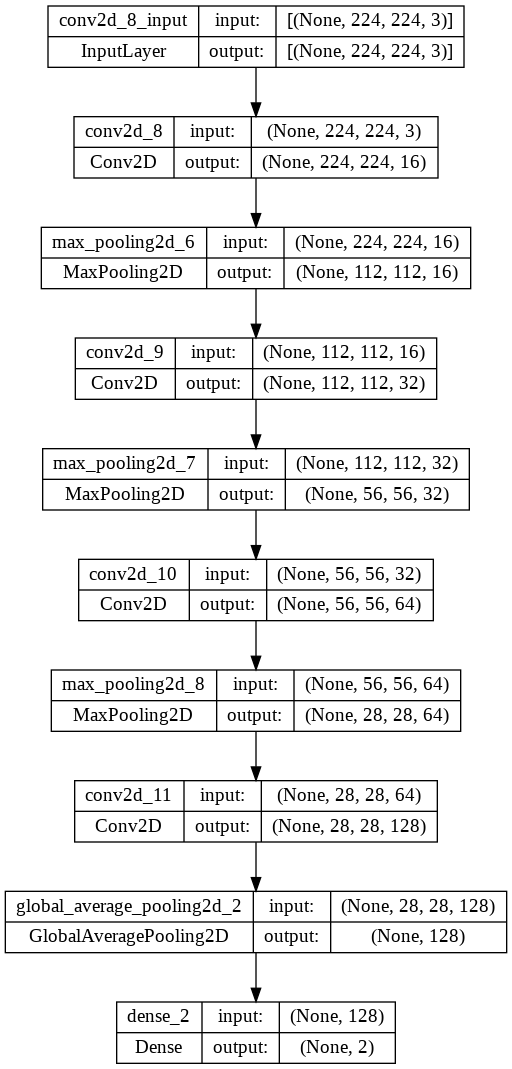

In [ ]:
# Model Visualization
from tensorflow.keras.utils import plot_model

plot_model(model, "model.png", show_shapes=True)

In [ ]:
model.layers

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
callbacks_list = [checkpoint]

In [ ]:
num_epochs = 16
steps_per_epoch_training = len(train_generator)
steps_per_epoch_validation = len(validation_generator)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch_training,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch_validation,
    verbose=1,
    callbacks=[callbacks_list]
)

Epoch 1/16


<ipython-input-57-2f55db239ca3>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


546/546 [==============================] - ETA: 0s - loss: 0.4472 - accuracy: 0.7853
Epoch 1: val_accuracy improved from -inf to 0.82500, saving model to best_model.h5
546/546 [==============================] - 316s 577ms/step - loss: 0.4472 - accuracy: 0.7853 - val_loss: 0.3969 - val_accuracy: 0.8250
Epoch 2/16
546/546 [==============================] - ETA: 0s - loss: 0.3624 - accuracy: 0.8366
Epoch 2: val_accuracy improved from 0.82500 to 0.85385, saving model to best_model.h5
546/546 [==============================] - 311s 570ms/step - loss: 0.3624 - accuracy: 0.8366 - val_loss: 0.3211 - val_accuracy: 0.8538
Epoch 3/16
546/546 [==============================] - ETA: 0s - loss: 0.3400 - accuracy: 0.8524
Epoch 3: val_accuracy improved from 0.85385 to 0.86923, saving model to best_model.h5
546/546 [==============================] - 310s 569ms/step - loss: 0.3400 - accuracy: 0.8524 - val_loss: 0.3111 - val_accuracy: 0.8692
Epoch 4/16
546/546 [==============================] - ETA: 0s -

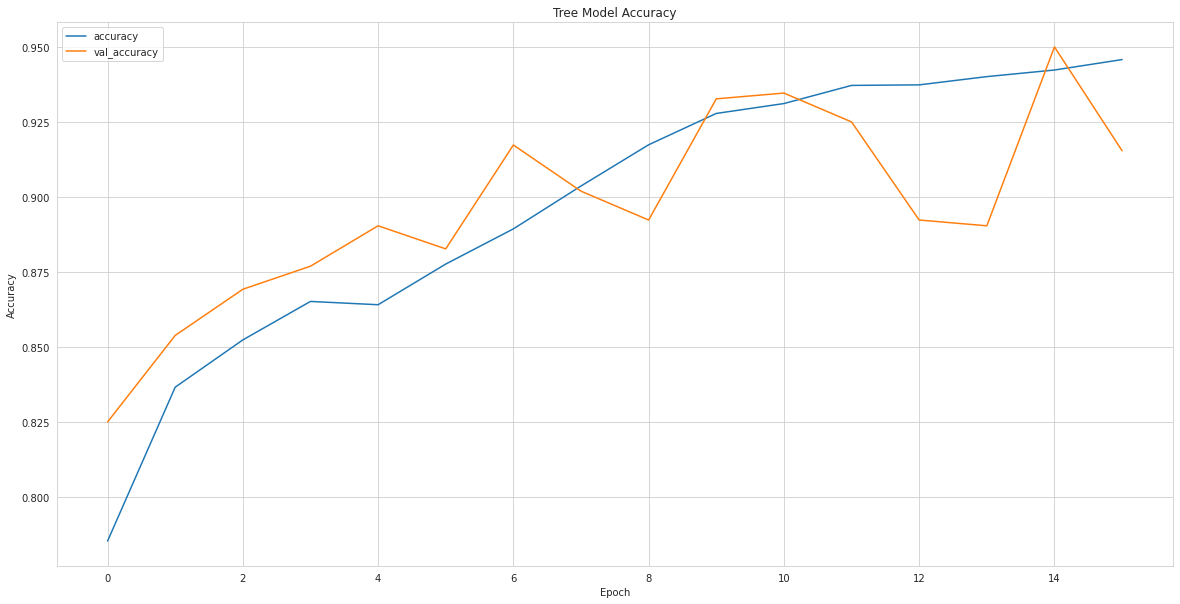

In [ ]:
plt.figure(figsize=(20, 10))
sns.set_style('whitegrid')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Tree Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.show()

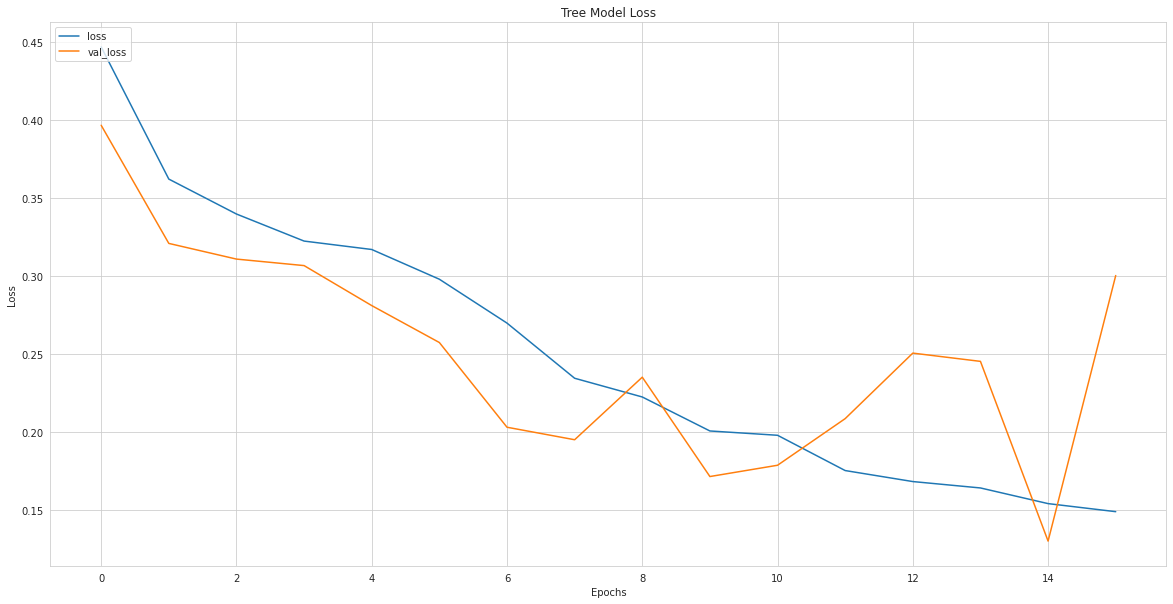

In [ ]:
plt.figure(figsize=(20, 10))
sns.set_style('whitegrid')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Tree Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

<br>
<h2 align=center id="build_cam">Building Class Activation Maps</h2>

In [ ]:
# select all the layers for which you want to visualize the outputs and store it in a list
outputs = [layer.output for layer in model.layers[1:9]]

# Define a new model that generates the above output
vis_model = Model(model.input, outputs)

# store the layer names we are interested in
layer_names = []
for layer in outputs:
    layer_names.append(layer.name.split("/")[0])

    
print("Layers that will be used for visualization: ")
print(layer_names)

Layers that will be used for visualization: 
['max_pooling2d_6', 'conv2d_9', 'max_pooling2d_7', 'conv2d_10', 'max_pooling2d_8', 'conv2d_11', 'global_average_pooling2d_2', 'dense_2']


In [ ]:
gap_weights = model.layers[-1].get_weights()[0]
gap_weights.shape

cam_model  = Model(inputs=model.input, outputs=(model.layers[-3].output,model.layers[-1].output))
cam_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8_input (InputLayer)  [(None, 224, 224, 3)]    0         
                                                                 
 conv2d_8 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 56, 56, 64)        1849

In [ ]:
class_mapping

{'NoTrees': 0, 'Trees': 1}

In [ ]:
def show_cam(image_value, features, results):
  '''
  Displays the class activation map of an image

  Args:
    image_value (tensor) -- preprocessed input image with size 224 x 224
    features (array) -- features of the image, shape (1, 28, 28, 128)
    results (array) -- output of the sigmoid layer
  '''

  # there is only one image in the batch so we index at `0`
  features_for_img = features[0]
  prediction = results[0]

  # there is only one unit in the output so we get the weights connected to it
  class_activation_weights = gap_weights[:,0]

  # upsample to the image size
  class_activation_features = sp.ndimage.zoom(features_for_img, (224/28, 224/28, 1), order=2)
  
  # compute the intensity of each feature in the CAM
  cam_output  = np.dot(class_activation_features,class_activation_weights)

  # visualize the results
  print(f'Output \nNo Trees Probability: {results[0][0]} \nTrees Probability: {results[0][1]}')
  plt.figure(figsize=(8, 8))
  plt.imshow(cam_output, cmap='jet', alpha=0.5)
  plt.imshow(tf.squeeze(image_value), alpha=0.5)
  plt.show()
  

In [ ]:
def convert_and_classify(image):

  # load the image
  img = cv2.imread(image)
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # preprocess the image before feeding it to the model
  img = cv2.resize(img, (224, 224)) / 255.0

  # add a batch dimension because the model expects it
  tensor_image = np.expand_dims(img, axis=0)

  # get the features and prediction
  features,results = cam_model.predict(tensor_image)
  
  # generate the CAM
  show_cam(tensor_image, features, results)

1/1 [==============================] - 0s 38ms/step
Output 
No Trees Probability: 0.9817560911178589 
Trees Probability: 0.01824396289885044


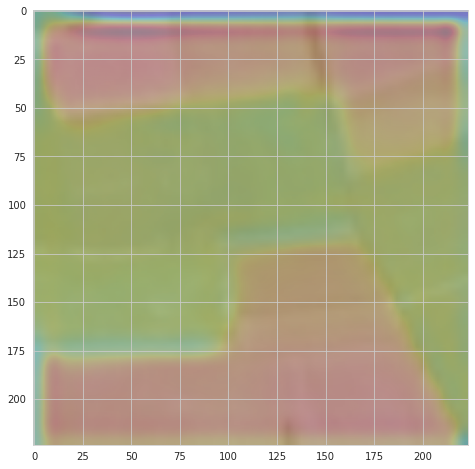

In [ ]:
convert_and_classify('/content/test/NoTrees/AnnualCrop_1045.jpg')

<br>
<h2 align=center id="make_dataframe">Make Dataframe for the Predictions</h2>

In [ ]:
test_generator=data_generator.flow_from_dataframe(
  dataframe=test_df,
  directory=test_dir,
  x_col="img_path",
  y_col="Label",
  batch_size=10,
  seed=42,
  shuffle=False,
  class_mode='categorical',
  target_size=(image_resize, image_resize),)

Found 1040 validated image filenames belonging to 2 classes.


In [ ]:
filenames=test_generator.filenames

In [ ]:
pred=model.predict_generator(test_generator, steps=len(test_generator), verbose=1).round(3)

<ipython-input-101-f85677f4f13d>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred=model.predict_generator(test_generator, steps=len(test_generator), verbose=1).round(3)


104/104 [==============================] - 20s 184ms/step


In [ ]:
filenames_df = pd.DataFrame(filenames, columns=['File Path'])
pred_df = pd.DataFrame(pred, columns=['NoTrees', 'Trees'])
model_predictions = pd.concat([filenames_df, pred_df], axis=1)
model_predictions

,File Path,NoTrees,Trees
0,/content/test/NoTrees/AnnualCrop_552.jpg,0.288,0.712
1,/content/test/NoTrees/Industrial_1972.jpg,0.992,0.008
2,/content/test/NoTrees/Industrial_2173.jpg,1.000,0.000
3,/content/test/Trees/Forest_320.jpg,0.012,0.988
4,/content/test/NoTrees/Industrial_91.jpg,0.999,0.001
...,...,...,...
1035,/content/test/Trees/River_1791.jpg,0.050,0.950
1036,/content/test/NoTrees/Industrial_657.jpg,0.998,0.002
1037,/content/test/Trees/Forest_2661.jpg,0.011,0.989
1038,/content/test/Trees/Forest_1467.jpg,0.322,0.678


In [ ]:
file_name='model_predictions.csv'
model_predictions.to_csv(file_name, sep=',', encoding='utf-8')

<br>
<h2 align=center id="upload_predict">Upload and Predict Your Picture!</h2>

Saving namib-desert.jpg to namib-desert.jpg
1/1 [==============================] - 0s 35ms/step
Output 
No Trees Probability: 0.9999996423721313 
Trees Probability: 3.4552368788354215e-07


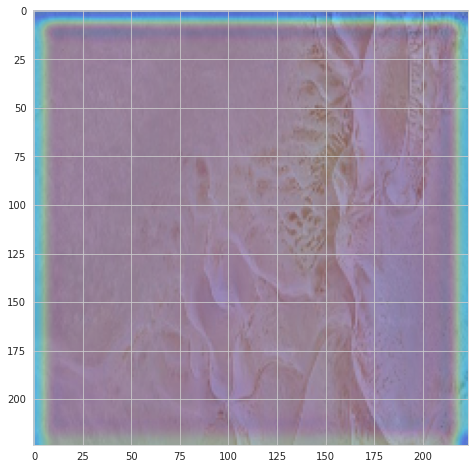

1/1 [==============================] - 0s 47ms/step
No Tree Probability: % 100.0
Tree Probability: % 0.0


In [ ]:
from google.colab import files
from keras.preprocessing import image
from numpy import asarray

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  width = 224
  height = 224
  dim = (width, height)
  path = '/content/' + fn
  img = cv2.imread(path)
  convert_and_classify(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, dim)
  x = asarray(img)
  x = np.expand_dims(x, axis=0)

  image_tensor = np.vstack([x])
  classes = model.predict(image_tensor)
  print("No Tree Probability: %", round(classes[0][0]*100, 2))
  print("Tree Probability: %", round(classes[0][1]*100, 2))

<h1>Contact Me</h1>
<p>If you have something to say to me please contact me:</p>

<ul>
  <li>Twitter: <a href="https://twitter.com/Doguilmak">Doguilmak</a></li>
  <li>Mail address: doguilmak@gmail.com</li>
</ul>

In [108]:
from datetime import datetime
print(f"Changes have been made to the project on {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Changes have been made to the project on 2022-12-17 16:32:50
